### 단어 빈도수를 활용한 감정 분류
---

- Reference
    - https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html

In [2]:
# Prevent Warnings message.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np


# 데이터 밸런스 맞춰 놓은 데이터 셋.
train_df = pd.read_csv('./data/train_data_11_23.csv', encoding='utf-8-sig')
test_df = pd.read_csv("./data/test_data_11_23.csv", encoding='utf-8-sig')

print(train_df.shape)
print(test_df.shape)

(29685, 2)
(3299, 2)


## Preprocessing Data

- 정규식과 Okt Tokenize 사용
- Clean Reivew Data
- 자세한 클리닝 방식은 TextPreProcessing code 참고.

In [2]:
# 텍스트 데이터 전처리 해주는 전처리 객체.
from konlpy.tag import Okt
from multiprocessing import Pool

import re
import pandas as pd


class TextPreProcessor(object):

    @staticmethod
    def __get_stop_words():
        """ 한국어 불용어 리스트 가져오기.
        영어는 nltk안에 내장된 불용어 리스트가 있지만
        한국어의 경우 없기 때문에 자료를 다운 받아 사용.

        Reference - https://bab2min.tistory.com/544
        :return: stop words
        """
        stop_words = []

        with open('./한국어불용어100.txt', 'r', encoding='utf-8-sig') as f:
            while True:
                a = f.readline()
                if a:
                    a = a.split()[0]
                    stop_words.append(a)
                else:
                    break
        return stop_words

    @staticmethod
    def review_to_wordlist(review: list, remove_stopwords=False) -> list:
        """ 텍스트 데이터 전처리 함수.

        :param review: input review or text data.
        :param remove_stopwords: whether remove stopwords
        :return:
        """
        # 1. 특수문자를 공백으로 바꿔줌
        review_text = re.sub("[^가-힣-ㄱ-ㅎㅏ-ㅣ\\s]", " ", review)

        # 3. 어간추출 (konlpy okt tokenize 사용)
        okt = Okt()
        words = okt.morphs(review_text, stem=True)

        # 4. 불용어 목록 가져오기
        stop_words = TextPreProcessor.__get_stop_words()

        # 5. 불용어 제거
        if remove_stopwords:
            words = [w for w in words if not w in stop_words]

        # 6. 리스트 형태로 반환
        return words

    @staticmethod
    def review_to_pos_words(review: list, remove_stopwords=False) -> list:
        """

        :param review: 텍스트 데이터
        :param remove_stopwords: 불용어 처리 여부.
        :return: 전처리된 텍스트 데이터
        """
        # 1. 특수문자를 공백으로 바꿔줌
        review_text = re.sub("[^가-힣-ㄱ-ㅎㅏ-ㅣ\\s]", " ", review)

        # 3. 어간추출 (konlpy okt tokenize 사용)
        okt = Okt()
        words = okt.pos(review_text, stem=True, norm=True)

        # 4. 불용어 목록 가져오기
        stop_words = TextPreProcessor.__get_stop_words()

        # 5. 불용어 제거
        if remove_stopwords:
            words = [w for w in words if not w in stop_words]

        # 6. 동사, 명사만 추출.
        result = []
        for w in words:
            if w[1] in ["Noun", "Verb"]:
                result.append(w[0])

        return result

    @staticmethod
    def review_to_join_words(review: list, remove_stopwords=False) -> str:
        """ word 단위로 토큰화 된 text 데이터를 합쳐주는 함수.

        :param review: input review or text data.
        :return: Tokenized sentences
        """
        words = TextPreProcessor.review_to_wordlist(\
            review, remove_stopwords=False)
        join_words = ' '.join(words)
        return join_words


    @staticmethod
    def review_to_sentences(review: list, remove_stopwords=False) -> list:
        """ 불용어 및 전처리 된 문장 데이터를 만들어 주는 함수.

        :param review: input review or text data.
        :return: sentences
        """
        okt = Okt()

        # 1. konlpy okt을 사용해서 단어로 토큰화 하고 공백 등을 제거한다.
        raw_sentences = okt.morphs(review.strip())

        # 2. 각 문장을 순회한다.
        sentences = []
        for raw_sentence in raw_sentences:
            # 비어있다면 skip
            if len(raw_sentence) > 0:
                # 태그제거, 알파벳문자가 아닌 것은 공백으로 치환, 불용어제거
                sentences.append(\
                    TextPreProcessor.review_to_wordlist(\
                    raw_sentence, remove_stopwords))
        return sentences


    # 참고 : https://gist.github.com/yong27/7869662
    # http://www.racketracer.com/2016/07/06/pandas-in-parallel/
    # 속도 개선을 위해 멀티 스레드로 작업하도록
    @staticmethod
    def _apply_df(args):
        df, func, kwargs = args
        return df.apply(func, **kwargs)

    @staticmethod
    def apply_by_multiprocessing(df: pd.DataFrame, func, **kwargs) -> pd.DataFrame:
        # 키워드 항목 중 workers 파라메터를 꺼냄
        workers = kwargs.pop('workers')
        # 위에서 가져온 workers 수로 프로세스 풀을 정의
        pool = Pool(processes=workers)
        # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
        result = pool.map(TextPreProcessor._apply_df, [(d, func, kwargs)
                for d in np.array_split(df, workers)])
        pool.close()
        # 작업 결과를 합쳐서 반환
        return pd.concat(result)

In [ ]:
# 멀티스레드로 4개의 워커를 사용해 처리한다.
def getCleanReviews(reviews):
    clean_reviews = []
    clean_reviews = TextPreProcessor.apply_by_multiprocessing(\
        reviews["review"], TextPreProcessor.review_to_wordlist,\
        workers=4)
    return clean_reviews

In [4]:
NUM_FEATURES = 300

%time train_x = getCleanReviews(train_df)


%time test_x = getCleanReviews(test_df)

Wall time: 1min 9s
Wall time: 18.4 s


In [5]:
# Get all tokens 
tokens = [d for token in train_x for d in token]

import nltk
from pprint import pprint
text = nltk.Text(tokens, name="NMSC")

print(len(text.tokens)) # all tokens
print(len(set(text.tokens))) # remove duplicate tokens
pprint(text.vocab().most_common(10)) # most common value top 10
print(len(tokens))

1331145
25896
[('이', 37780),
 ('하다', 34760),
 ('에', 25773),
 ('가', 20126),
 ('도', 17859),
 ('는', 17783),
 ('먹다', 17091),
 ('\n', 16944),
 ('은', 16787),
 ('있다', 16541)]
1331145


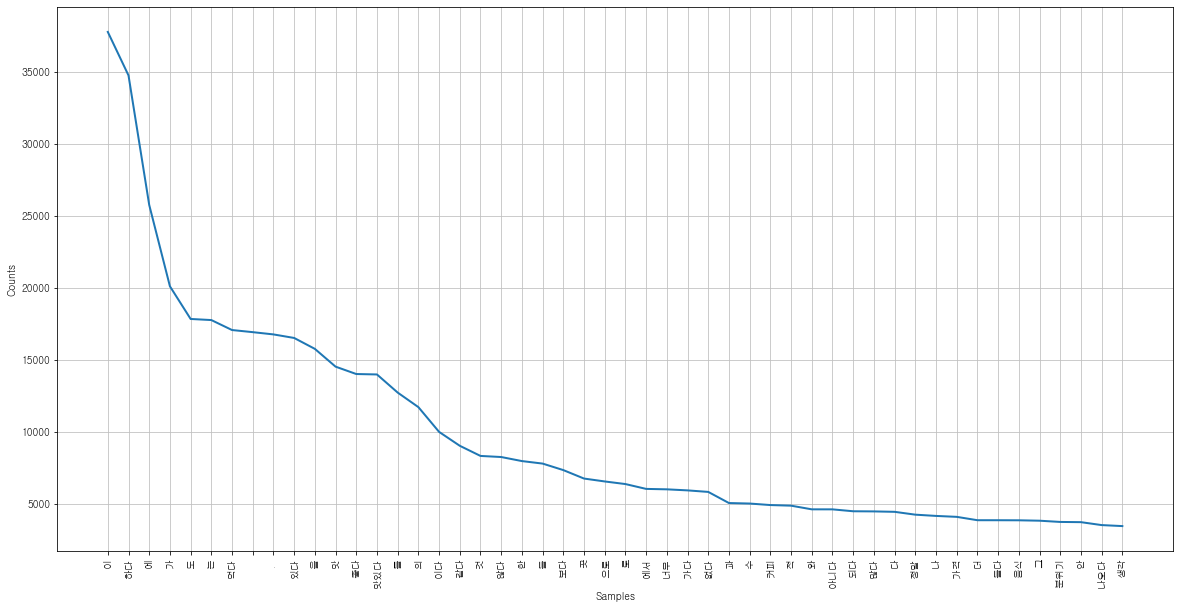

In [6]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [8]:
# select most common value and 
""" Vectoring data with 10000 most commonly used tokens.

Use CountVectorization instead of One Hot Encoding.

This creates a word token in the set of review data and 
counts the number of each word to create the BOW encoded vector. 
"""
selected_words = [f[0] for f in text.vocab().most_common(10000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d in train_x]
test_x = [term_frequency(d) for d in test_x]

train_y = [score for score in train_df['score']]
test_y  = [score for score in test_df['score']]



29685 [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 

In [11]:

print(len(train_x), len(train_y))
print(len(test_x), len(test_y))

29685 29685
3299 3299


In [12]:
import numpy as np

# Data type Casting to float.
train_x = np.asarray(train_x).astype('float32')
train_y = np.asarray(train_y).astype('float32')

test_x = np.asarray(test_x).astype('float32')
test_y = np.asarray(test_y).astype('float32')

In [18]:
# Modeling.

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from keras_radam import RAdam

model_1 = models.Sequential()
model_1.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(32, activation='relu'))
model_1.add(layers.Dense(32, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))


model_1.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model1_y_score = model_1.fit(train_x, train_y, epochs=20, batch_size=512)
model1_results = model_1.evaluate(test_x, test_y)

print("\n\nTest Data Result : Loss : {}, Accuracy : {}".format(model1_results[0], model1_results[1]))

Epoch 1/20
29685/29685 [==============================] - 2s 71us/sample - loss: 0.5535 - binary_accuracy: 0.7328
Epoch 2/20
29685/29685 [==============================] - 2s 65us/sample - loss: 0.4111 - binary_accuracy: 0.8097
Epoch 3/20
29685/29685 [==============================] - 2s 66us/sample - loss: 0.3339 - binary_accuracy: 0.8514
Epoch 4/20
29685/29685 [==============================] - 2s 68us/sample - loss: 0.2574 - binary_accuracy: 0.8907
Epoch 5/20
29685/29685 [==============================] - 2s 66us/sample - loss: 0.1847 - binary_accuracy: 0.9282
Epoch 6/20
29685/29685 [==============================] - 2s 65us/sample - loss: 0.1442 - binary_accuracy: 0.9482
Epoch 7/20
29685/29685 [==============================] - 2s 66us/sample - loss: 0.1029 - binary_accuracy: 0.9635
Epoch 8/20
29685/29685 [==============================] - 2s 66us/sample - loss: 0.0925 - binary_accuracy: 0.9699
Epoch 9/20
29685/29685 [==============================] - 2s 69us/sample - loss: 0.0709 

In [19]:
%env TF_KERAS = 1
import os 
from keras_radam.training import RAdamOptimizer


model_2 = models.Sequential()
model_2.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))


model_2.compile(optimizer=RAdamOptimizer(learning_rate=1e-3), 
               loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model2_y_score = model_2.fit(train_x, train_y, epochs=20, batch_size=512)
model2_results = model_2.evaluate(test_x, test_y)

print("\n\nTest Data Result : Loss : {}, Accuracy : {}".format(model2_results[0], model2_results[1]))

env: TF_KERAS=1
Epoch 1/20
29685/29685 [==============================] - 3s 86us/sample - loss: 0.6876 - binary_accuracy: 0.6097
Epoch 2/20
29685/29685 [==============================] - 2s 77us/sample - loss: 0.5970 - binary_accuracy: 0.7554
Epoch 3/20
29685/29685 [==============================] - 2s 76us/sample - loss: 0.4688 - binary_accuracy: 0.7959
Epoch 4/20
29685/29685 [==============================] - 2s 74us/sample - loss: 0.3755 - binary_accuracy: 0.8368
Epoch 5/20
29685/29685 [==============================] - 2s 76us/sample - loss: 0.2910 - binary_accuracy: 0.8748
Epoch 6/20
29685/29685 [==============================] - 2s 74us/sample - loss: 0.2110 - binary_accuracy: 0.9154
Epoch 7/20
29685/29685 [==============================] - 2s 75us/sample - loss: 0.1463 - binary_accuracy: 0.9458
Epoch 8/20
29685/29685 [==============================] - 2s 75us/sample - loss: 0.1100 - binary_accuracy: 0.9611
Epoch 9/20
29685/29685 [==============================] - 2s 77us/sample

In [21]:
from sklearn.metrics import roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt 

y_pred_1 = model_1.predict(test_x).ravel()
fpr1, tpr1, thresholds = roc_curve(test_y, y_pred_1)
auc_curve = auc(fpr1, tpr1)
auc_curve

0.8055810392495444

In [22]:
y_pred_2 = model_2.predict(test_x).ravel()
fpr2, tpr2, thresholds = roc_curve(test_y, y_pred_2)
auc_curve = auc(fpr2, tpr2)
auc_curve

0.815629210782249

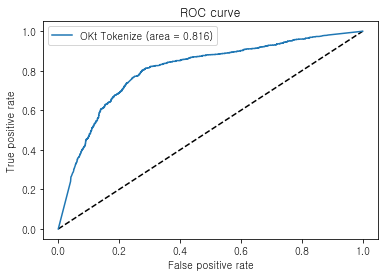

In [23]:
# Draw plot.
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='OKt Tokenize (area = {:.3f})'.format(auc_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

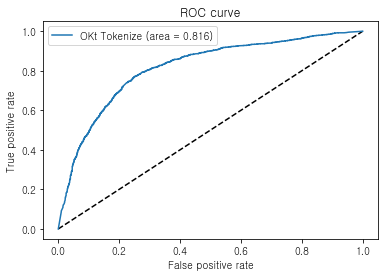

In [24]:
# Draw plot.
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2, label='OKt Tokenize (area = {:.3f})'.format(auc_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [31]:
# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [33]:
test_y

array([1., 0., 0., ..., 1., 1., 0.], dtype=float32)

In [36]:
y_pred_1 = [1 if y >= 0.5 else 0 for y in y_pred_1]

y_pred_2 = [1 if y >= 0.5 else 0 for y in y_pred_2]

In [55]:
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIG_SIZE = 50
LARGE_SIZE = 40

params = {
    'figure.figsize': (40, 20),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

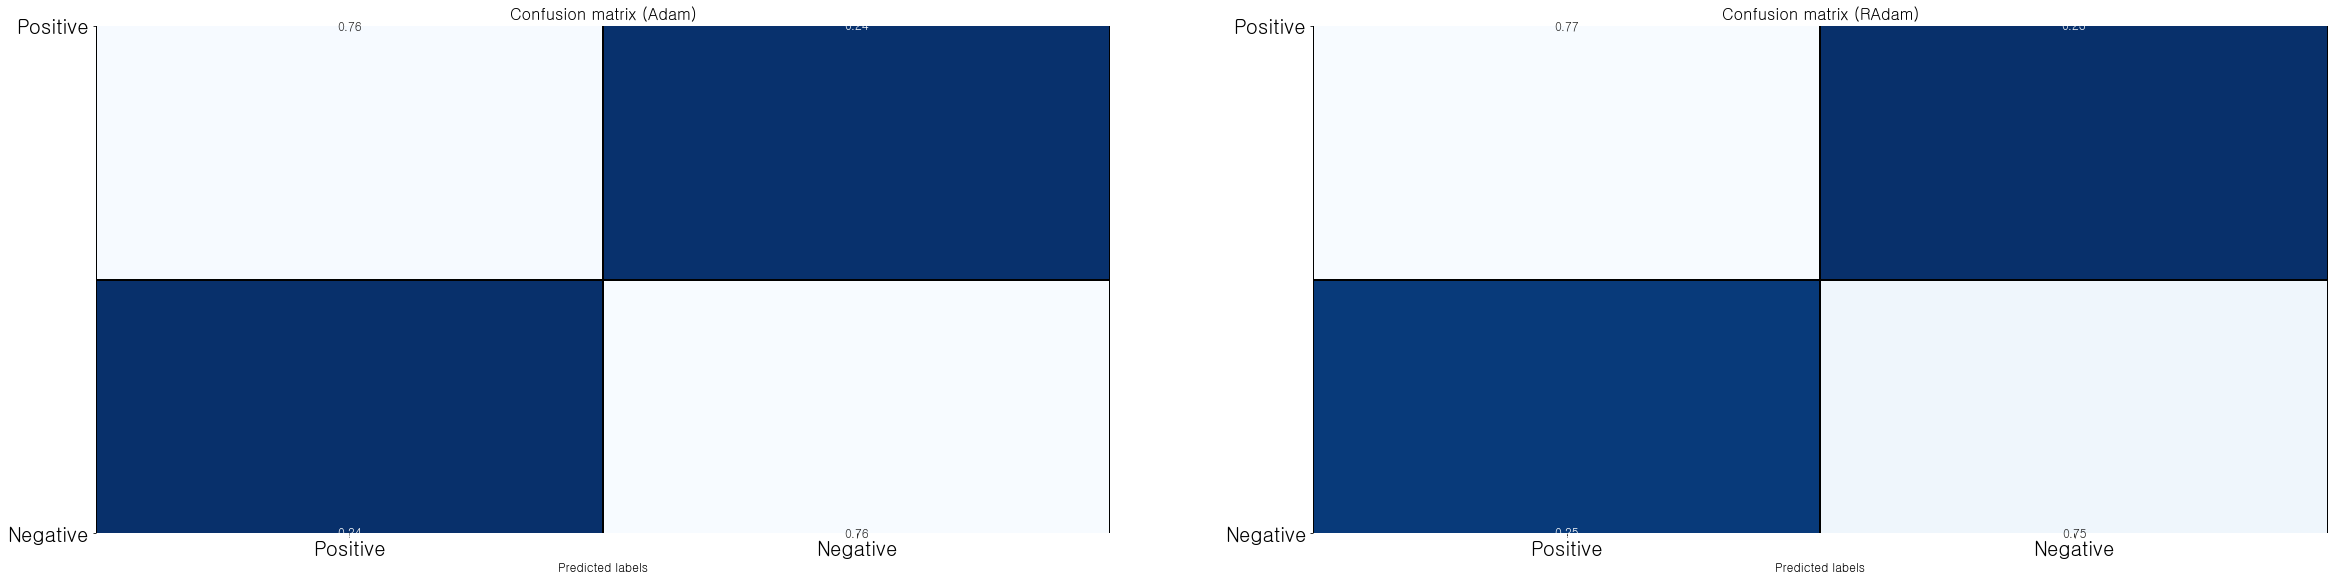

In [56]:
import matplotlib.pyplot as plt
import seaborn as sb
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(test_y, y_pred_1, ax=axis1,
                      title='Confusion matrix (Adam)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(test_y, y_pred_2, ax=axis2,
                      title='Confusion matrix (RAdam)',
                      class_names=['Positive', 'Negative'])

### Save DataSet

In [ ]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [ ]:
import numpy as np

# Data type Casting to float.
train_x = np.asarray(train_x).astype('float32')
train_y = np.asarray(train_y).astype('float32')

test_x = np.asarray(test_x).astype('float32')
test_y = np.asarray(test_y).astype('float32')

In [57]:
import os

DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'

if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

# 전처리 된 학습 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_x)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_y)

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_x)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_y)